# Предсказание ротамеров угла $\chi_1$ в зависимости от окружения

In [92]:
import json
import pandas as pd
import numpy as np
import seaborn as sns

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lime.lime_tabular

In [94]:
%matplotlib inline

## Запустите следующую клетку. Будет случайно выбрана аминокислота, для которой вы будете проводить исследование

In [229]:
amacid_names = ['ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'HIS', 'ILE', 'LEU',
                'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

#print(f"Моя аминокислота - {np.random.choice(amacid_names)}")

Моя аминокислота - MET. Запишу, так как может поменяться, если нажму run all cells

## Загрузите <a href="https://yadi.sk/d/FeLl5KYfjbhHgA?w=1">отсюда</a> соответствующий файл. Далее мы будем работать с ним.

# Часть 1. Анализ значений угла $\chi_1$

## Задание 1.1. Откроем загруженный файл. Посмотрим на колонки:

In [96]:
dpath = '/Users/alena/Desktop/masters_hw_materials/Proteins/hw3/MET_data.csv'

In [97]:
df = pd.read_csv(dpath, index_col=0)

In [98]:
df.head()

pbd_indx         phi        psi        tau      alpha  ind_from_start  \
0     2BO5  -71.696126 -36.491955  92.365999  63.703292              50   
1     2BO5 -100.136368   2.375129  90.201119  52.345175              71   
2     2BO5  -83.409476 -25.116380  91.208269  60.203946             107   
3     2BO5  -76.152451 -13.264322  88.631593  50.853604             108   
4     2BW2  -61.689072 -29.589444  86.110294  65.003986              35   

   ind_from_end sec_structure  is_tail       chi_1  ...     gamma14  \
0            69             H        0  -73.594937  ...   61.115372   
1            48             H        0 -176.849366  ...   98.230230   
2            12             H        0  -63.894178  ...   91.481464   
3            11             H        0   65.541023  ...   81.815079   
4           104             H        0  -80.341087  ...  104.855807   

     alpha15      beta15     gamma15    alpha16      beta16     gamma16  \
0  21.182993  149.840690  108.080818  81.146452  127.430867   57.156980   
1  63.152892  161.189883   75.081490  82.914303   47.873674   48.164025   
2  47.406297  162.104827   92.179099  98.155986  101.721317  161.183722   
3  80.120462  148.856269  107.791163  30.338553   78.607616   59.746902   
4  27.927479   55.460576  116.950597  18.585800   76.010778   95.318609   

     alpha17      beta17     gamma17  
0  30.160503  129.505987   60.667653  
1  14.546059   92.156908   86.440087  
2  35.059535  108.053039  124.972422  
3  20.719416   62.927025  106.488175  
4  83.174567  100.843495   18.571909  

[5 rows x 301 columns]

Эта таблица содержит информацию о сэмплах одной аминокислоты. Для каждого сэмпла известны:
- Значения всех двугранных углов $\chi$;
- Значения $\phi, \psi, \alpha$ (двугранный угол, построенный по 4 последовательным атомам $C_\alpha$);
- Данные о 17 ближайших пространственных соседях:
    - $\phi, \psi$;
    - Названия аминокислот;
    - Расстояние до целевой аминокислоты по $C_\alpha$;
    - Химические / физикохимические характеристики соседа: группы и точные значения некоторых характеристик;
    - Дополнительные геометрические характеристики (относительно целевой аминокислоты).

## Задание 1.2. Постройте гистограмму значений $\chi_1$ из этой таблицы. Какие ротамеры выделяются на этой гистограмме?

In [99]:
import matplotlib.pyplot as plt

In [100]:
df = df[~np.isnan(df["chi_1"])]

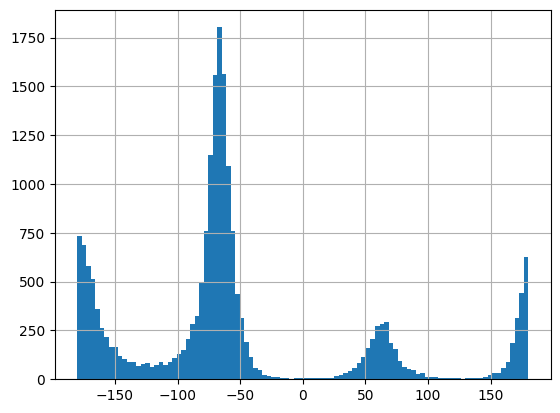

In [101]:
df["chi_1"].hist(bins=100);

Занесите обнаруженные ротамеры в список rotamers:

In [102]:
rotamers = np.array([-180, -60, 60])

## Задание 1.3. Давайте разберемся, как можно дискретизировать значения (разделить их на классы). Реализуйте функцию get_class(value, rotamers), которая возвращает индекс ротамера, к которому относится значение value.

**Комментарий**: стоит вычислять расстояние от value до каждого значения из rotamers. Но не забудьте, что с точки зрения окружности $-\pi$ и $\pi$ - одно и то же!

In [103]:
def get_class(value, rotamers):
    diffs = np.abs(value - rotamers)
    diffs = np.minimum(diffs, 360-diffs)
    return np.argmin(diffs)

In [104]:
get_class(-121, rotamers)

0

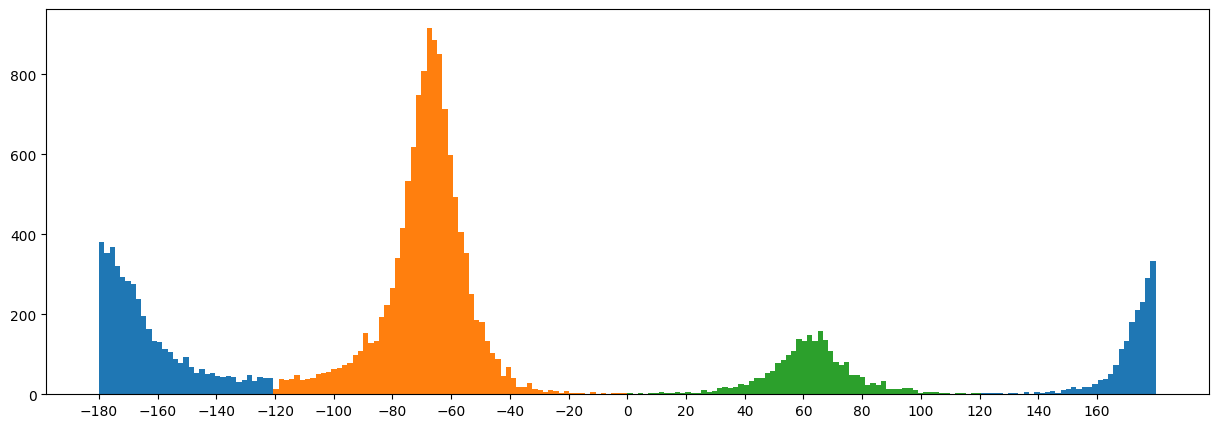

In [105]:
plt.figure(figsize=(15,5))
classes = [get_class(val, rotamers) for val in df['chi_1']]

for i in np.unique(classes):
    plt.hist(df["chi_1"].values[classes == i], bins=200, range=(-180, 180))

plt.xticks(np.arange(-180, 180, 20))
plt.show()

## Задание 1.4. Теперь мы умеем делить значения $\chi_1$ на классы, т.е. можем понять, к какому ротамеру относится то или иное значение.
Реализуем первую часть подхода Dunbrack. Шаги:
- Разделить карту Рамачандрана на блоки $20 x 20$. Для каждого блока нужно найти те сэмплы из выборки, которые входят в него.
- Для всех найденных сэмплов нужно получить индексы классов; после этого выбрать класс, встречающийся чаще всего, и сохранить его в соответствующую ячейку матрицы **most_common_rotamers**.
    - Если получилось меньше 10 значений для некоторого блока, нужно получить наиболее частый класс для всей выборки.

In [106]:
all_rots = [get_class(val, rotamers) for val in df['chi_1']]
all_un_rots, all_un_cnts = np.unique(all_rots, return_counts=True)
            
most_common = all_un_rots[np.argmax(all_un_cnts)] # Здесь нужно записать индекс ротамера, наиболее часто встречающегося во всей выборке.

In [107]:
most_common_rotamers = np.full((18, 18), np.nan)
for phi_ind in range(18):
    phi_st = -180 + 20 * phi_ind
    phi_end = -180 + 20 * (phi_ind + 1)
    for psi_ind in range(18):  
        psi_st = -180 + 20 * psi_ind
        psi_end = -180 + 20 * (psi_ind + 1)
        
        loc_data = df[(df['phi'] >= phi_st) & (df['phi'] < phi_end)
                     & (df['psi'] >= psi_st) & (df['psi'] < psi_end)]
        
        if loc_data.shape[0] < 10:
            most_common_rotamers[psi_ind, phi_ind] = most_common
        else:
            loc_rots = [get_class(val, rotamers) 
                        for val in loc_data['chi_1']]
            loc_un_rots, loc_un_cnts = np.unique(loc_rots, 
                                                 return_counts=True)
            most_common_rotamers[psi_ind, phi_ind] = loc_un_rots[np.argmax(loc_un_cnts)]

Отобразите получившуюся матрицу с помощью plt.imshow: 

In [108]:
most_common_rotamers.shape

(18, 18)

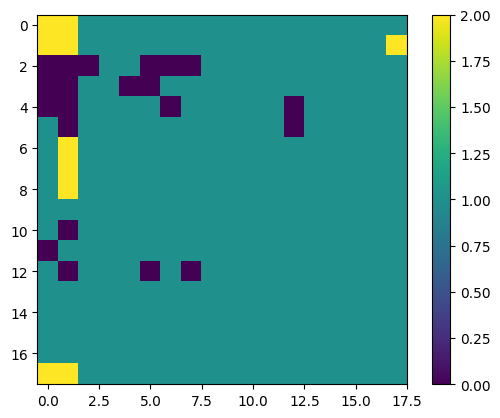

In [109]:
plt.imshow(most_common_rotamers[::-1])

plt.colorbar()
plt.show()

# $\rightarrow$ Ваши идеи 🙂

Какие выводы можно сделать на основании изображения выше? Можно ли сказать, что какой-то ротамер характерен для определенной вторичной структуры?

Можно предположить, что есть зависимость между ротамером и вторичной структурой. Для b листов чаще всего встречается ротамер 0, около -180 градусов, и 2 (60 градусов). Для остальных областей - чаще всего характерен 1 ротамер (около -60), что видно и на гистограмме  

## Задание 1.5. А насколько вообще состоятелен подход к поиску пересечений, основанный на энергии van der Waals?

Давайте возьмем достаточно длинный белок $1Z87$, откроем его и изучим:

In [110]:
import Bio.PDB as pdb

In [111]:
path = pdb.PDBList().retrieve_pdb_file("1z87", 
                                       file_format="pdb")
struct = pdb.PDBParser().get_structure("s", path)

Structure exists: '/Users/alena/Desktop/masters_hw_materials/Proteins/hw3/z8/pdb1z87.ent' 


Получите 0-ую цепочку этого белка, найдите в ней индексы всех цистеинов (CYS):

In [112]:
chain = struct[0].child_list[0]
residues = chain.child_list
cys_inds = [i for i in range(len(chain))
           if residues[i].resname == 'CYS']
cys_inds

[15, 218, 231]

Выберите первый найденный цистеин. Будем менять для него угол $\chi_1$ и смотреть, как будет меняться энергия ван дер Ваальса при взаимодействии с другими атомами.

$U_{LJ} = 4 \cdot \epsilon \cdot [(\frac{r_{min}}{r})^{12} - 2 \cdot (\frac{r_{min}}{r})^6]$

In [113]:
lj_coeffs = pd.read_csv("./lennard-jones_12-6.csv", delimiter="\t")
lj_coeffs.head()

atom_pair  reqm    eps
0       C-C     4   0,15
1       C-N  3,75  0,155
2       C-O   3,6  0,173
3       C-S     4  0,173
4       C-H     3  0,055

In [114]:
def van_der_Waals(d, d_m, eps):
    return  4 * eps * (((d_m / d) ** 12) - 2 * ((d_m / d) ** 6))

Изменяя двугранный угол в пределах $[-\pi, \pi)$:
- Вычислите новые координаты атома SG у цистеина. Для этого можно воспользоваться функциями из файла geometry.py (из первого ДЗ).
- После получения координат, их можно присвоить с помощью метода:

    residue["CG"].set_coord(new_cg1_coord)
- После этого вычислите суммарную энергию ван дер Ваальса взаимодействия со всеми другими атомами белка.

In [115]:
from geometry import *

Для удобства сделаем словарь из таблицы с коэффициентами потенциала типа Леннарда-Джонса:

In [116]:
lj_coeffs = {row[0]: {"d_min": float(row[1].replace(",", ".")), 
                      "eps": float(row[2].replace(",", "."))} for row in lj_coeffs.values}
lj_coeffs

{'C-C': {'d_min': 4.0, 'eps': 0.15},
 'C-N': {'d_min': 3.75, 'eps': 0.155},
 'C-O': {'d_min': 3.6, 'eps': 0.173},
 'C-S': {'d_min': 4.0, 'eps': 0.173},
 'C-H': {'d_min': 3.0, 'eps': 0.055},
 'N-C': {'d_min': 3.75, 'eps': 0.155},
 'N-N': {'d_min': 3.5, 'eps': 0.16},
 'N-O': {'d_min': 3.35, 'eps': 0.179},
 'N-S': {'d_min': 3.75, 'eps': 0.179},
 'N-H': {'d_min': 2.75, 'eps': 0.057},
 'O-C': {'d_min': 3.6, 'eps': 0.173},
 'O-N': {'d_min': 3.35, 'eps': 0.179},
 'O-O': {'d_min': 3.2, 'eps': 0.2},
 'O-S': {'d_min': 3.6, 'eps': 0.2},
 'O-H': {'d_min': 2.6, 'eps': 0.063},
 'S-C': {'d_min': 4.0, 'eps': 0.173},
 'S-N': {'d_min': 3.75, 'eps': 0.179},
 'S-O': {'d_min': 3.6, 'eps': 0.2},
 'S-S': {'d_min': 4.0, 'eps': 0.2},
 'S-H': {'d_min': 3.0, 'eps': 0.063},
 'H-C': {'d_min': 3.0, 'eps': 0.055},
 'H-N': {'d_min': 2.75, 'eps': 0.057},
 'H-O': {'d_min': 2.6, 'eps': 0.063},
 'H-S': {'d_min': 3.0, 'eps': 0.063},
 'H-H': {'d_min': 2.0, 'eps': 0.02}}

In [117]:
def calc_vdw_w_residue(ref_residue, residue):
    ref_atoms = [at 
                 for at in ref_residue.child_list 
                 if at not in ["C", "N", "CA", "CB", "O"] and at.element[0] != "H"]
    atoms = [at 
             for at in residue.child_list 
             if at.element[0] != "H"]
    
    ds, d_ms, epses = [], [], []
    for at1 in ref_atoms:
        for at2 in atoms:
            pair = "{}-{}".format(at1.element, at2.element)
            ds += [at1 - at2]
            d_ms += [lj_coeffs[pair]["d_min"]]
            epses += [lj_coeffs[pair]["eps"]]
            
    ds =    np.array(ds)
    d_ms =  np.array(d_ms)
    epses = np.array(epses)
    
    return van_der_Waals(ds, d_ms, epses).sum()
    

In [118]:
calc_vdw_w_residue(chain[2], chain[3])

157461.58689638547

In [119]:
chi1_vals = np.arange(-np.pi, np.pi, np.pi/10)

cys_residue = residues[cys_inds[0]]

chi1_true = pdb.calc_dihedral(cys_residue["N"].get_vector(),
                              cys_residue["CA"].get_vector(),
                              cys_residue["CB"].get_vector(),
                              cys_residue["SG"].get_vector(),                             
                             )
planar = pdb.calc_angle(cys_residue["CA"].get_vector(),
                      cys_residue["CB"].get_vector(),
                      cys_residue["SG"].get_vector())
bond = cys_residue["SG"] - cys_residue["CB"]
prev_atoms = np.array([cys_residue["N"].coord, 
                       cys_residue["CA"].coord, 
                       cys_residue["CB"].coord, 
                      ])

vdw_vals = []

for chi1 in chi1_vals:
    new_coord = place_next_dihedral_atom(prev_atoms, chi1, planar, bond)
    cys_residue["SG"].set_coord(new_coord)
    
    vdw_sum = 0
    for k in range(len(residues)):
        if k == cys_inds[0]:
            continue
        
        vdw_sum += calc_vdw_w_residue(cys_residue, residues[k])
    
    vdw_vals += [vdw_sum]

Постройте график для получившихся значений энергии. Какой вывод можно сделать из него?

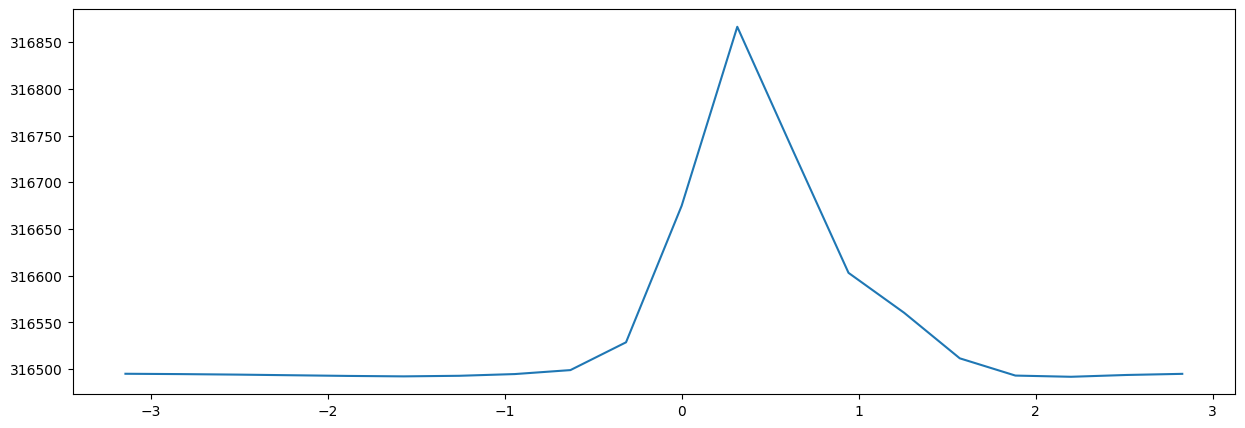

In [120]:
plt.figure(figsize=(15,5))
plt.plot(chi1_vals, vdw_vals)
#plt.plot([chi1_true, chi1_true], [0, max(vdw_vals)])
plt.show()

На графике один пик в районе 0.3 радиан, это около 15-20 градусов. 

# Часть 2. Предсказание ротамеров $\chi_1$

В этой части Вам предстоит применить методы Машинного Обучения (деревья решений) к задаче предсказания ротамеров Вашей аминокислоты.

## Задание 2.1. Вернемся к датасету из части 1. Добавьте колонку chi_class, которая получается преобразованием значений из колонки chi_1 к классам.

Бинаризирую значения с помощью функции get_class и значения ротамеров. Получается 3 класса (всего 3 ротамера)

In [121]:
#plt.style.use('ggplot')

In [122]:
df['chi_class'] = df['chi_1'].apply(lambda x: get_class(x, rotamers))

In [123]:
vl = df['chi_class'].value_counts().reset_index().sort_values('chi_class')
vl = vl.rename({'index': 'class', 'chi_class': 'number of chi angles'}, axis=1)
vl

class  number of chi angles
2      2                  2337
1      0                  6215
0      1                 11962

In [2]:
plt.figure(figsize=(4, 3))
sns.barplot(data=vl, x='class', y='number of chi angles',hue="angles");

NameError: name 'plt' is not defined

## Задание 2.2. Теперь давайте дискретизируем значения $\phi, \psi, \alpha$. Каждому значению из $[-\pi, \pi]$ нужно поставить в соответствие номер блока длиной 20 градусов, в который он попадает.

**Комментарий**: обратите внимание, значения могут быть отрицательными. А номер блока нет 🤔

Бинаризирую значения. Прибавляю 180, чтобы не было отрицательных значений. Получается 18 классов

In [125]:
def discrete_values(x):
    return int((x + 180) / 20) 

In [126]:
df['phi_class'] = df['phi'].apply(discrete_values)
df['psi_class'] = df['psi'].apply(discrete_values)
df['alpha_class'] = df['alpha'].apply(discrete_values)

In [127]:
df['phi_class'].value_counts()

5     7687
4     3025
6     2919
3     2308
2     2201
1     1340
0      398
11     214
12     186
7      113
17      59
10      29
8       12
13      11
9        7
14       3
16       1
15       1
Name: phi_class, dtype: int64

In [128]:
df['psi_class'].value_counts()

7     4442
6     4287
15    2856
16    2789
8     1321
14    1157
17    1110
9      627
13     392
10     355
5      347
12     270
11     234
0      212
4       44
1       41
3       16
2       14
Name: psi_class, dtype: int64

In [129]:
df['alpha_class'].value_counts()

11    6738
0     1954
1     1845
12    1551
2     1539
3     1216
17    1091
10    1043
4      645
13     625
16     511
14     476
9      322
15     318
5      231
8      157
7      129
6      123
Name: alpha_class, dtype: int64

## Задание 2.3. В датасете есть текстовые признаки! Так как они категориальные, их значения можно поменять на натуральные числа. Пронумеруйте все уникальные значения таких признаков и измените текстовые значения на соответствующие номера. 

**Пропущенные значения**

In [130]:
df.isnull().sum().sort_values(ascending=False).head(20)

n_psi_16    82
n_phi_16    82
n_psi_17    63
n_phi_17    63
n_psi_15    50
n_phi_15    50
n_phi_9     48
n_psi_9     48
n_psi_13    44
n_phi_13    44
n_phi_12    43
n_psi_12    43
n_psi_8     42
n_phi_8     42
n_phi_14    41
n_psi_14    41
n_phi_11    40
n_psi_10    40
n_phi_10    40
n_psi_11    40
dtype: int64

Визуализирую некоторые признаки, где есть пропущенные значения

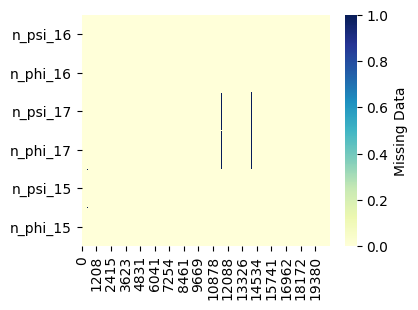

In [131]:
plt.figure(figsize=(4, 3))
sns.heatmap(df[['n_psi_16', 'n_phi_16', 'n_psi_17',
               'n_phi_17', 'n_psi_15', 'n_phi_15']].isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'});

Пропущенные значения есть, но и их не так много. Видимо у одного набора переменных есть пропущенные значения. В документации lightgbm написано, что по дефолту (не нужны дополнительные параметры) модель может работать с пропусками. Не буду убирать пропущенные значения 

**Категориальные переменные**

In [132]:
df_cat = df.select_dtypes(include=[object])
print(f'Всего {df_cat.shape[1]} категориальных переменных')

Всего 138 категориальных переменных


У нас около половины категориальных переменных, возможно тут хорошо сработал бы catboost

In [133]:
X = df.copy()

In [134]:
label_encode = LabelEncoder()

In [135]:
df.columns.get_loc('psi')

2

In [136]:
for col in df.columns:
    if X[col].dtype == object:
        label_encode.fit(X[col])
        X[col + '_encoded'] = label_encode.transform(X[col])
        X = X.drop(labels=col, axis=1)

In [137]:
X.head()

phi        psi        tau      alpha  ind_from_start  ind_from_end  \
0  -71.696126 -36.491955  92.365999  63.703292              50            69   
1 -100.136368   2.375129  90.201119  52.345175              71            48   
2  -83.409476 -25.116380  91.208269  60.203946             107            12   
3  -76.152451 -13.264322  88.631593  50.853604             108            11   
4  -61.689072 -29.589444  86.110294  65.003986              35           104   

   is_tail       chi_1       chi_2       chi_3  ...  \
0        0  -73.594937  -54.090688  -38.147631  ...   
1        0 -176.849366  170.099956   63.056127  ...   
2        0  -63.894178  -61.071217 -144.490712  ...   
3        0   65.541023   86.864754 -166.972185  ...   
4        0  -80.341087 -116.947291   52.525565  ...   

   n_16_physicochemical_group_encoded  n_16_polarity_group_encoded  \
0                                   8                            0   
1                                   3                            1   
2                                   3                            1   
3                                   6                            1   
4                                   3                            1   

   n_16_volume_group_encoded  n_17_charge_group_encoded  \
0                          0                          2   
1                          0                          2   
2                          0                          2   
3                          4                          2   
4                          0                          2   

   n_17_chemical_group_encoded  n_17_hydrogen_donor_acceptor_group_encoded  \
0                            1                                           3   
1                            5                                           2   
2                            1                                           3   
3                            1                                           3   
4                            1                                           3   

   n_17_hydropathy_group_encoded  n_17_physicochemical_group_encoded  \
0                              2                                   5   
1                              2                                   6   
2                              1                                   1   
3                              1                                   1   
4                              1                                   1   

   n_17_polarity_group_encoded  n_17_volume_group_encoded  
0                            0                          4  
1                            1                          4  
2                            0                          0  
3                            0                          4  
4                            0                          4  

[5 rows x 305 columns]

Закодированы категориальные переменные

## Задание 2.4. Обучим нашу модель!

Импортируйте библиотеку lightgbm. Если она не установлена, установить ее можно с помощью консольной команды pip:

In [138]:
# Ваш pip может иметь другую версию / называться по-другому: например, pip3 для python3
#! pip3.8 install lightgbm
import lightgbm as lgb

Разделите выборку на обучающую и тестовую в соотношении 0.7/0.3. В X должны быть все признаки, кроме Unnamed, pdb_id и всех столбцов со значениями углов $\chi$. y - столбец дискретизированных значений $\chi_1$.

In [139]:
y = X['chi_class']

In [140]:
for c in df.columns.tolist():
    if 'chi' in c:
        print(c)

chi_1
chi_2
chi_3
chi_class


In [142]:
X = X.drop(['pbd_indx_encoded', 'chi_1','chi_2','chi_3','chi_class'], axis=1)

In [52]:
X.head(5)

phi        psi        tau      alpha  ind_from_start  ind_from_end  \
0  -71.696126 -36.491955  92.365999  63.703292              50            69   
1 -100.136368   2.375129  90.201119  52.345175              71            48   
2  -83.409476 -25.116380  91.208269  60.203946             107            12   
3  -76.152451 -13.264322  88.631593  50.853604             108            11   
4  -61.689072 -29.589444  86.110294  65.003986              35           104   

   is_tail     n_phi_1    n_psi_1     n_phi_2  ...  \
0        0  -66.498802 -31.013310  -57.974789  ...   
1        0 -108.282667 -21.997056  -66.725318  ...   
2        0  -91.320899 -29.285039  -76.152451  ...   
3        0  -83.409476 -25.116380  -95.615338  ...   
4        0  -62.603932 -33.242635 -109.271940  ...   

   n_16_physicochemical_group_encoded  n_16_polarity_group_encoded  \
0                                   8                            0   
1                                   3                            1   
2                                   3                            1   
3                                   6                            1   
4                                   3                            1   

   n_16_volume_group_encoded  n_17_charge_group_encoded  \
0                          0                          2   
1                          0                          2   
2                          0                          2   
3                          4                          2   
4                          0                          2   

   n_17_chemical_group_encoded  n_17_hydrogen_donor_acceptor_group_encoded  \
0                            1                                           3   
1                            5                                           2   
2                            1                                           3   
3                            1                                           3   
4                            1                                           3   

   n_17_hydropathy_group_encoded  n_17_physicochemical_group_encoded  \
0                              2                                   5   
1                              2                                   6   
2                              1                                   1   
3                              1                                   1   
4                              1                                   1   

   n_17_polarity_group_encoded  n_17_volume_group_encoded  
0                            0                          4  
1                            1                          4  
2                            0                          0  
3                            0                          4  
4                            0                          4  

[5 rows x 300 columns]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Обучите модель, проверьте качество обучения на тестовой выборке (по метрике accuracy). Получилось ли хорошая модель?

In [54]:
clf = lgb.LGBMClassifier(num_leaves=88,
                         min_child_samples=1358,
                         max_depth=16,
                         n_estimators=2170,
                         reg_lambda=702.599,
                         reg_alpha=28.532,
                         learning_rate=0.26461,
                         random_state=42
                        )

In [55]:
clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.26461, max_depth=16, min_child_samples=1358,
               n_estimators=2170, num_leaves=88, random_state=42,
               reg_alpha=28.532, reg_lambda=702.599)

In [56]:
y_pred = clf.predict(X_test)

In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy score:", accuracy)

Test accuracy score: 0.6690495532087734


Качество модели выше, чем случайное. При случайном было бы ~0.33, так как 3 класса. Но accuracy 0.67 сложно назвать хорошим качеством( 

## Интерпретация важности признаков

Посмотрим на значимость признаков

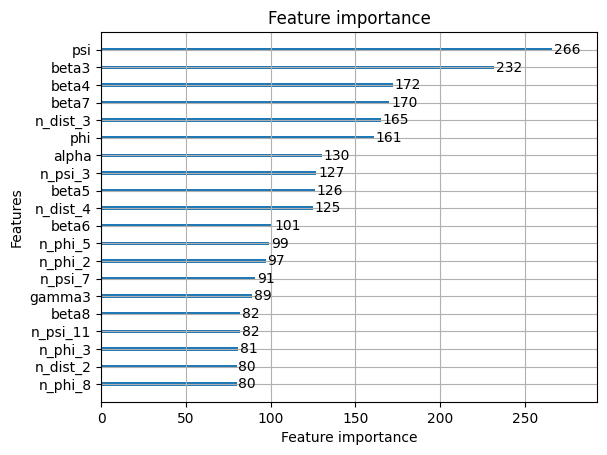

In [59]:
from lightgbm import plot_importance
plot_importance(clf, max_num_features=20);

Для предсказания важны значения углов psi, phi и n_name_. n_name - это закодированные аминокислоты

**LIME**

Попробую использовать библиотеку Lime для интерпретации важности признаков. Но у нее есть несколько минусов: работает только c n сэмплами из датасета, нельзя усреднить важность признаков на всем датасете. Также не работает, если есть пропущенные значения, поэтому пришлось пересохранить X_train

In [60]:
X_train_tmp = X_train.copy()
X_train_tmp['y_train'] = y_train

In [61]:
X_train_tmp = X_train_tmp.dropna()

In [62]:
y_train_tmp = X_train_tmp['y_train']
X_train_tmp = X_train_tmp.drop('y_train', axis=1)

In [63]:
predict_fn = lambda x: clf.predict_proba(x)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_tmp.astype(int).values, 
                                                   mode='classification',
                                                   class_names=[0, 1, 2],
                                                   training_labels=y_train_tmp,
                                                   feature_names=X_train_tmp.columns)

In [64]:
print(f'Истинный класс: {y_test.iloc[0]}, предсказанный класс: {y_pred[0]}')

Истинный класс: 1, предсказанный класс: 1


In [65]:
exp = explainer.explain_instance(X_test.iloc[0], predict_fn,
                                 num_features=10)
exp.show_in_notebook(show_all=False)

Prediction probabilities - показывает вероятность каждого класса. Следующий график показывает, какие признаки делают наибольший вклад в предсказание класса (при чем, не обязательного верного, а просто наиболее вероятного). В таблице выделены признаки, которые также делают в предсказание наиболее вероятного класса или других классов   

In [66]:
print(f'Истинный класс: {y_test.iloc[2]}, предсказанный класс: {y_pred[2]}')

Истинный класс: 1, предсказанный класс: 1


In [67]:
exp = explainer.explain_instance(X_test.iloc[2], predict_fn,
                                 num_features=10)
exp.show_in_notebook(show_all=False)

In [68]:
print(f'Истинный класс: {y_test.iloc[1]}, предсказанный класс: {y_pred[1]}')

Истинный класс: 2, предсказанный класс: 1


На этом примере модель ошиблась. На графике вывожу 2 label и те признаки, которые помогли его предсказать

In [69]:
exp = explainer.explain_instance(X_test.iloc[1], predict_fn,
                                 num_features=10, labels=(2,))
exp.show_in_notebook(show_all=False)

In [70]:
print(f'Истинный класс: {y_test.iloc[7]}, предсказанный класс: {y_pred[7]}')

Истинный класс: 2, предсказанный класс: 2


In [71]:
exp = explainer.explain_instance(X_test.iloc[7], predict_fn,
                                 num_features=10, labels=(2,))
exp.show_in_notebook(show_all=False)

Красиво, конечно, но я ожидала чего-то большего( Lime не понравился, толком нет документации. Да и сложно делать какие-то выводы на основе одного семпла

Про признаки выглядит будто phi и psi иногда наводят суету, то есть они наиболее часто встречаются среди тех признаков, которые были важны для предсказания неверного класса. Попробовала обучить модель без них, но это только ухудшило результат 

**SHAP**

In [72]:
import shap

In [73]:
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

In [74]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

У shap много красивых графиков, но что-то сложно их интерпретировать 

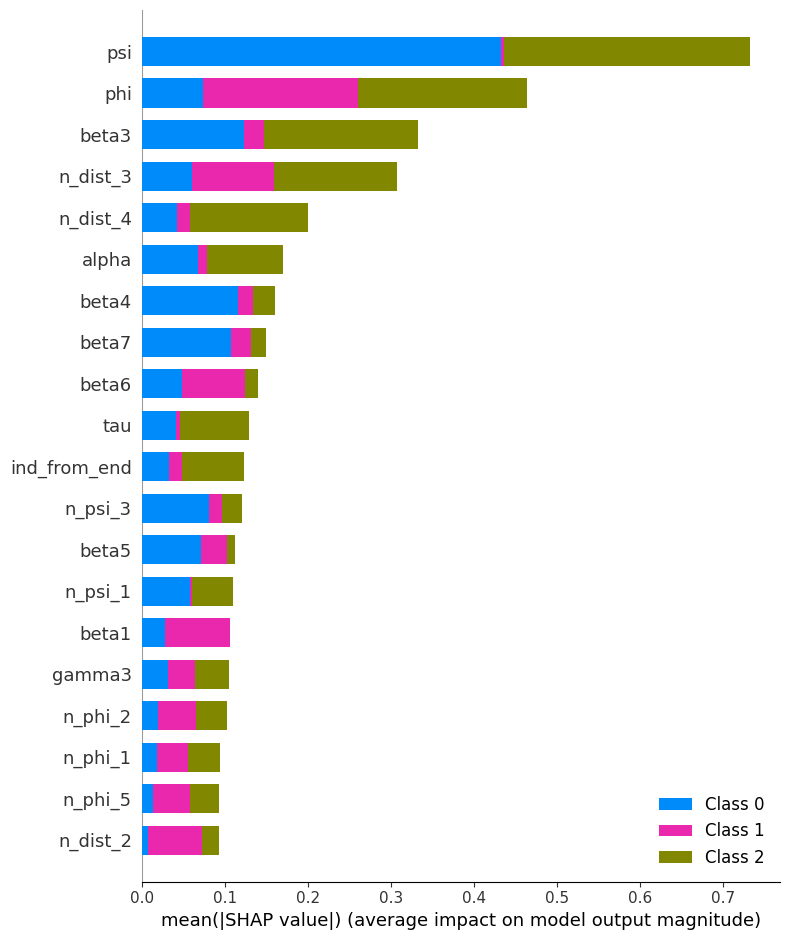

In [75]:
shap.summary_plot(shap_values, X_test)

Признаки отсортированы по значимости для предсказания. Каждый столбец раскрашен по цветам классов. Например, первый столбец отвечает за признак psi. Мы видим, что psi помогает предсказать класс 0 и класс 2, но не класс 1

Также из выводов можно сказать то, что ни одна модель интерпретации признаков не выдала категориальные признаки как важные

## Подбор гиперпараметров

Попробую библиотеку optuna, она более оптимально подбирает параметры нежели gridsearch или в цикле. Источник, где подглядывала код: https://www.kaggle.com/code/saurabhshahane/lgbm-hyperparameter-tuning-with-optuna-beginners

In [76]:
import optuna

На основе данных параметров задаю границы новых:

```clf = lgb.LGBMClassifier(num_leaves=88,
                         min_child_samples=1358,
                         max_depth=16,
                         n_estimators=2170,
                         reg_lambda=702.599,
                         reg_alpha=28.532,
                         learning_rate=0.26461,
                         random_state=42
                        )```

In [78]:
def objective(trial):
    
    param = {'num_leaves': trial.suggest_int('num_leaves', 2, 252, 10),
             'min_child_samples': trial.suggest_int('min_child_samples', 1300, 1480, 30),
             'max_depth': trial.suggest_int('max_depth', 10, 20, 2),
             'n_estimators': trial.suggest_int('n_estimators', 1900, 2900, 100),
             'reg_lambda': trial.suggest_float('reg_lambda', 650.0, 750.0, log=True),
             'reg_alpha': trial.suggest_float('reg_alpha', 15.0, 30.0, log=True),
             'learning_rate': trial.suggest_categorical('learning_rate', np.arange(0.001, 0.3, 0.01))}

    
    clf = lgb.LGBMClassifier(num_leaves=param['num_leaves'],
                             min_child_samples=param['min_child_samples'],
                             max_depth=param['max_depth'],
                             n_estimators=param['n_estimators'],
                             reg_lambda=param['reg_lambda'],
                             reg_alpha=param['reg_alpha'],
                             learning_rate=param['learning_rate'],
                             random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

Подбор должен остановиться или через 150 итераций, или 2 часа

In [79]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150, timeout=7200, n_jobs=-1, show_progress_bar=True)

[I 2022-12-04 13:29:51,581] A new study created in memory with name: no-name-1f7cc49c-74c7-4c22-878d-601de86ece7f
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


[I 2022-12-04 13:31:48,236] Trial 4 finished with value: 0.6706742485783915 and parameters: {'num_leaves': 222, 'min_child_samples': 1450, 'max_depth': 16, 'n_estimators': 2200, 'reg_lambda': 723.1271512569117, 'reg_alpha': 24.352864043070287, 'learning_rate': 0.16099999999999998}. Best is trial 4 with value: 0.6706742485783915.
[I 2022-12-04 13:31:51,204] Trial 5 finished with value: 0.6656376929325751 and parameters: {'num_leaves': 152, 'min_child_samples': 1480, 'max_depth': 10, 'n_estimators': 2300, 'reg_lambda': 653.5096816385758, 'reg_alpha': 25.896069803840973, 'learning_rate': 0.13099999999999998}. Best is trial 4 with value: 0.6706742485783915.
[I 2022-12-04 13:32:08,574] Trial 0 finished with value: 0.6690495532087734 and parameters: {'num_leaves': 222, 'min_child_samples': 1390, 'max_depth': 18, 'n_estimators': 1900, 'reg_lambda': 694.4390933217595, 'reg_alpha': 23.925298551146216, 'learning_rate': 0.141}. Best is trial 4 with value: 0.6706742485783915.
[I 2022-12-04 13:32:2

[I 2022-12-04 13:38:54,025] Trial 26 finished with value: 0.6705117790414298 and parameters: {'num_leaves': 172, 'min_child_samples': 1330, 'max_depth': 20, 'n_estimators': 2000, 'reg_lambda': 655.2481301687357, 'reg_alpha': 15.013550247971738, 'learning_rate': 0.291}. Best is trial 15 with value: 0.6722989439480097.
[I 2022-12-04 13:39:03,071] Trial 22 finished with value: 0.6703493095044679 and parameters: {'num_leaves': 82, 'min_child_samples': 1300, 'max_depth': 20, 'n_estimators': 1900, 'reg_lambda': 668.7494765629588, 'reg_alpha': 16.30701061116863, 'learning_rate': 0.19099999999999998}. Best is trial 15 with value: 0.6722989439480097.
[I 2022-12-04 13:39:17,388] Trial 25 finished with value: 0.6750609260763607 and parameters: {'num_leaves': 172, 'min_child_samples': 1330, 'max_depth': 20, 'n_estimators': 2100, 'reg_lambda': 656.664552012873, 'reg_alpha': 15.054920854897034, 'learning_rate': 0.22099999999999997}. Best is trial 25 with value: 0.6750609260763607.
[I 2022-12-04 13:3

[I 2022-12-04 13:49:18,134] Trial 49 finished with value: 0.670186839967506 and parameters: {'num_leaves': 152, 'min_child_samples': 1360, 'max_depth': 10, 'n_estimators': 2300, 'reg_lambda': 693.3117248224988, 'reg_alpha': 16.74238086946505, 'learning_rate': 0.17099999999999999}. Best is trial 25 with value: 0.6750609260763607.
[I 2022-12-04 13:49:39,489] Trial 47 finished with value: 0.669374492282697 and parameters: {'num_leaves': 142, 'min_child_samples': 1360, 'max_depth': 10, 'n_estimators': 2300, 'reg_lambda': 707.4665247165512, 'reg_alpha': 17.870996523529914, 'learning_rate': 0.071}. Best is trial 25 with value: 0.6750609260763607.
[I 2022-12-04 13:50:34,482] Trial 51 finished with value: 0.6700243704305443 and parameters: {'num_leaves': 252, 'min_child_samples': 1390, 'max_depth': 10, 'n_estimators': 2300, 'reg_lambda': 709.9682278434657, 'reg_alpha': 20.39983755421243, 'learning_rate': 0.12099999999999998}. Best is trial 25 with value: 0.6750609260763607.
[I 2022-12-04 13:50

[I 2022-12-04 14:01:04,465] Trial 72 finished with value: 0.6716490658001625 and parameters: {'num_leaves': 182, 'min_child_samples': 1450, 'max_depth': 12, 'n_estimators': 2800, 'reg_lambda': 650.4255507372849, 'reg_alpha': 16.353394449990667, 'learning_rate': 0.19099999999999998}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:01:37,142] Trial 73 finished with value: 0.6716490658001625 and parameters: {'num_leaves': 162, 'min_child_samples': 1420, 'max_depth': 16, 'n_estimators': 2000, 'reg_lambda': 666.5495657764957, 'reg_alpha': 16.37662716570901, 'learning_rate': 0.141}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:01:55,489] Trial 75 finished with value: 0.6688870836718115 and parameters: {'num_leaves': 162, 'min_child_samples': 1450, 'max_depth': 16, 'n_estimators': 2000, 'reg_lambda': 663.8596159176068, 'reg_alpha': 16.271019444318437, 'learning_rate': 0.141}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:02:09,849] Tr

[I 2022-12-04 14:10:49,913] Trial 100 finished with value: 0.6696994313566207 and parameters: {'num_leaves': 172, 'min_child_samples': 1360, 'max_depth': 10, 'n_estimators': 2200, 'reg_lambda': 689.3192504512741, 'reg_alpha': 17.122875361318155, 'learning_rate': 0.23099999999999996}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:10:51,656] Trial 98 finished with value: 0.670186839967506 and parameters: {'num_leaves': 152, 'min_child_samples': 1360, 'max_depth': 12, 'n_estimators': 2200, 'reg_lambda': 682.19794521241, 'reg_alpha': 18.388442673138822, 'learning_rate': 0.16099999999999998}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:11:14,944] Trial 96 finished with value: 0.664825345247766 and parameters: {'num_leaves': 182, 'min_child_samples': 1420, 'max_depth': 12, 'n_estimators': 1900, 'reg_lambda': 681.3267356239462, 'reg_alpha': 15.326171198323788, 'learning_rate': 0.020999999999999998}. Best is trial 54 with value: 0.6758732737611698.
[I 

[I 2022-12-04 14:17:43,857] Trial 125 finished with value: 0.6672623883021933 and parameters: {'num_leaves': 142, 'min_child_samples': 1330, 'max_depth': 14, 'n_estimators': 2100, 'reg_lambda': 692.1699181662656, 'reg_alpha': 27.407101481950715, 'learning_rate': 0.25099999999999995}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:17:50,947] Trial 118 finished with value: 0.6731112916328188 and parameters: {'num_leaves': 112, 'min_child_samples': 1300, 'max_depth': 14, 'n_estimators': 2000, 'reg_lambda': 683.8397094508803, 'reg_alpha': 29.14158662497303, 'learning_rate': 0.05099999999999999}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:18:44,548] Trial 120 finished with value: 0.6713241267262389 and parameters: {'num_leaves': 122, 'min_child_samples': 1300, 'max_depth': 18, 'n_estimators': 2000, 'reg_lambda': 684.0631977954368, 'reg_alpha': 20.916335844258587, 'learning_rate': 0.08099999999999999}. Best is trial 54 with value: 0.6758732737611698.

[I 2022-12-04 14:24:28,639] Trial 145 finished with value: 0.6718115353371243 and parameters: {'num_leaves': 212, 'min_child_samples': 1360, 'max_depth': 10, 'n_estimators': 2300, 'reg_lambda': 694.4147484943938, 'reg_alpha': 16.131526132975, 'learning_rate': 0.21099999999999997}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:24:52,540] Trial 147 finished with value: 0.6722989439480097 and parameters: {'num_leaves': 132, 'min_child_samples': 1300, 'max_depth': 10, 'n_estimators': 2300, 'reg_lambda': 694.1141186136341, 'reg_alpha': 15.009304782711073, 'learning_rate': 0.21099999999999997}. Best is trial 54 with value: 0.6758732737611698.
[I 2022-12-04 14:24:58,144] Trial 146 finished with value: 0.6713241267262389 and parameters: {'num_leaves': 132, 'min_child_samples': 1360, 'max_depth': 10, 'n_estimators': 2100, 'reg_lambda': 705.1287219814984, 'reg_alpha': 16.55995228294839, 'learning_rate': 0.10099999999999998}. Best is trial 54 with value: 0.6758732737611698.
[I

In [82]:
print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 150
Best trial:
  Value: 0.6758732737611698
  Params: 
    num_leaves: 142
    min_child_samples: 1390
    max_depth: 10
    n_estimators: 2300
    reg_lambda: 692.2104311886254
    reg_alpha: 16.736358880015562
    learning_rate: 0.17099999999999999


Подбор гиперпараметров улучшил результат модели на 0.01. Не сильно значимо, но чуть-чуть лучше!

## Catboost

In [153]:
from catboost import Pool, CatBoostClassifier

In [208]:
df.head(3)

pbd_indx         phi        psi        tau      alpha  ind_from_start  \
0     2BO5  -71.696126 -36.491955  92.365999  63.703292              50   
1     2BO5 -100.136368   2.375129  90.201119  52.345175              71   
2     2BO5  -83.409476 -25.116380  91.208269  60.203946             107   

   ind_from_end sec_structure  is_tail       chi_1  ...    alpha16  \
0            69             H        0  -73.594937  ...  81.146452   
1            48             H        0 -176.849366  ...  82.914303   
2            12             H        0  -63.894178  ...  98.155986   

       beta16     gamma16    alpha17      beta17     gamma17  chi_class  \
0  127.430867   57.156980  30.160503  129.505987   60.667653          1   
1   47.873674   48.164025  14.546059   92.156908   86.440087          0   
2  101.721317  161.183722  35.059535  108.053039  124.972422          1   

   phi_class  psi_class  alpha_class  
0          5          7           12  
1          3          9           11  
2          4          7           12  

[3 rows x 305 columns]

In [209]:
X = df.copy()

In [210]:
X = X.dropna() # вроде можно заменить пропуски на строку 'nan', но для упрощения выкину

In [211]:
y = X['chi_class']

In [212]:
X = X.drop(['pbd_indx', 'chi_1','chi_2','chi_3','chi_class'], axis=1)

Записываю индексы категориальных переменных 

In [213]:
cats_indx = []
for col in X.columns[X.dtypes=='object']:
    cats_indx.append(X.columns.get_loc(col))
len(cats_indx) # всего таких признаков

137

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [215]:
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cats_indx)

test_dataset = Pool(data=X_test,
                    label=y_test,
                    cat_features=cats_indx)

Параметры для CatBoost выбираю на основе тех, что были для lightgbm. Наверное, это лучше, чем дефолтные 

In [216]:
model = CatBoostClassifier(n_estimators=2300,
                           learning_rate=1,
                           depth=10,
                           l2_leaf_reg = 692,
                           loss_function='MultiClass',
                           random_state=42)

In [220]:
model.fit(train_dataset)

0:	learn: 0.9421541	total: 1.04s	remaining: 40m 2s
1:	learn: 0.8853090	total: 1.18s	remaining: 22m 39s
2:	learn: 0.8811778	total: 2.29s	remaining: 29m 15s
3:	learn: 0.8778272	total: 3.26s	remaining: 31m 11s
4:	learn: 0.8750131	total: 4.22s	remaining: 32m 19s
5:	learn: 0.8605547	total: 4.39s	remaining: 27m 57s
6:	learn: 0.8578173	total: 5.27s	remaining: 28m 47s
7:	learn: 0.8548909	total: 6.18s	remaining: 29m 30s
8:	learn: 0.8527415	total: 7.21s	remaining: 30m 35s
9:	learn: 0.8406295	total: 7.75s	remaining: 29m 33s
10:	learn: 0.8386529	total: 8.51s	remaining: 29m 31s
11:	learn: 0.8290428	total: 9.35s	remaining: 29m 41s
12:	learn: 0.8265834	total: 10.2s	remaining: 29m 58s
13:	learn: 0.8241405	total: 11s	remaining: 30m 3s
14:	learn: 0.8213693	total: 12s	remaining: 30m 29s
15:	learn: 0.8197377	total: 13s	remaining: 30m 58s
16:	learn: 0.8175861	total: 14.1s	remaining: 31m 28s
17:	learn: 0.8146135	total: 15.1s	remaining: 31m 59s
18:	learn: 0.8128483	total: 16s	remaining: 32m 2s
19:	learn: 0.8

154:	learn: 0.6825696	total: 2m 28s	remaining: 34m 15s
155:	learn: 0.6816784	total: 2m 29s	remaining: 34m 12s
156:	learn: 0.6808864	total: 2m 30s	remaining: 34m 12s
157:	learn: 0.6803185	total: 2m 31s	remaining: 34m 14s
158:	learn: 0.6793972	total: 2m 32s	remaining: 34m 16s
159:	learn: 0.6791998	total: 2m 33s	remaining: 34m 16s
160:	learn: 0.6785638	total: 2m 35s	remaining: 34m 19s
161:	learn: 0.6781829	total: 2m 35s	remaining: 34m 18s
162:	learn: 0.6774676	total: 2m 36s	remaining: 34m 17s
163:	learn: 0.6770275	total: 2m 37s	remaining: 34m 15s
164:	learn: 0.6762306	total: 2m 38s	remaining: 34m 14s
165:	learn: 0.6751917	total: 2m 39s	remaining: 34m 13s
166:	learn: 0.6749954	total: 2m 40s	remaining: 34m 13s
167:	learn: 0.6741601	total: 2m 41s	remaining: 34m 14s
168:	learn: 0.6735155	total: 2m 42s	remaining: 34m 12s
169:	learn: 0.6729469	total: 2m 43s	remaining: 34m 12s
170:	learn: 0.6722364	total: 2m 45s	remaining: 34m 14s
171:	learn: 0.6716163	total: 2m 46s	remaining: 34m 16s
172:	learn

304:	learn: 0.5952948	total: 4m 54s	remaining: 32m 4s
305:	learn: 0.5945848	total: 4m 55s	remaining: 32m 2s
306:	learn: 0.5941697	total: 4m 55s	remaining: 32m
307:	learn: 0.5940837	total: 4m 57s	remaining: 32m 2s
308:	learn: 0.5934832	total: 4m 58s	remaining: 32m 2s
309:	learn: 0.5934100	total: 4m 59s	remaining: 32m 1s
310:	learn: 0.5928968	total: 5m	remaining: 32m 1s
311:	learn: 0.5923687	total: 5m 1s	remaining: 32m 1s
312:	learn: 0.5921126	total: 5m 2s	remaining: 31m 59s
313:	learn: 0.5915300	total: 5m 3s	remaining: 31m 57s
314:	learn: 0.5912563	total: 5m 4s	remaining: 31m 56s
315:	learn: 0.5912215	total: 5m 5s	remaining: 32m
316:	learn: 0.5905930	total: 5m 6s	remaining: 31m 58s
317:	learn: 0.5900385	total: 5m 7s	remaining: 31m 57s
318:	learn: 0.5895176	total: 5m 8s	remaining: 31m 55s
319:	learn: 0.5889195	total: 5m 9s	remaining: 31m 53s
320:	learn: 0.5884425	total: 5m 10s	remaining: 31m 51s
321:	learn: 0.5878241	total: 5m 10s	remaining: 31m 50s
322:	learn: 0.5873206	total: 5m 11s	re

455:	learn: 0.5256343	total: 7m 11s	remaining: 29m 6s
456:	learn: 0.5251359	total: 7m 12s	remaining: 29m 5s
457:	learn: 0.5246389	total: 7m 13s	remaining: 29m 5s
458:	learn: 0.5242607	total: 7m 14s	remaining: 29m 3s
459:	learn: 0.5237717	total: 7m 15s	remaining: 29m 3s
460:	learn: 0.5233121	total: 7m 16s	remaining: 29m 2s
461:	learn: 0.5229061	total: 7m 17s	remaining: 29m
462:	learn: 0.5224048	total: 7m 18s	remaining: 29m
463:	learn: 0.5219178	total: 7m 19s	remaining: 28m 59s
464:	learn: 0.5214307	total: 7m 20s	remaining: 28m 58s
465:	learn: 0.5209978	total: 7m 21s	remaining: 28m 56s
466:	learn: 0.5204439	total: 7m 22s	remaining: 28m 55s
467:	learn: 0.5199788	total: 7m 23s	remaining: 28m 54s
468:	learn: 0.5195636	total: 7m 23s	remaining: 28m 53s
469:	learn: 0.5195140	total: 7m 25s	remaining: 28m 52s
470:	learn: 0.5190039	total: 7m 26s	remaining: 28m 52s
471:	learn: 0.5186851	total: 7m 26s	remaining: 28m 51s
472:	learn: 0.5182481	total: 7m 27s	remaining: 28m 49s
473:	learn: 0.5177623	to

606:	learn: 0.4664892	total: 10m 13s	remaining: 28m 31s
607:	learn: 0.4661048	total: 10m 14s	remaining: 28m 29s
608:	learn: 0.4656573	total: 10m 15s	remaining: 28m 28s
609:	learn: 0.4653126	total: 10m 16s	remaining: 28m 26s
610:	learn: 0.4649119	total: 10m 16s	remaining: 28m 25s
611:	learn: 0.4648355	total: 10m 18s	remaining: 28m 24s
612:	learn: 0.4644461	total: 10m 18s	remaining: 28m 23s
613:	learn: 0.4640856	total: 10m 19s	remaining: 28m 22s
614:	learn: 0.4635941	total: 10m 20s	remaining: 28m 20s
615:	learn: 0.4633299	total: 10m 21s	remaining: 28m 19s
616:	learn: 0.4629049	total: 10m 22s	remaining: 28m 17s
617:	learn: 0.4624891	total: 10m 23s	remaining: 28m 16s
618:	learn: 0.4622005	total: 10m 24s	remaining: 28m 16s
619:	learn: 0.4618046	total: 10m 25s	remaining: 28m 15s
620:	learn: 0.4614999	total: 10m 26s	remaining: 28m 14s
621:	learn: 0.4611144	total: 10m 27s	remaining: 28m 13s
622:	learn: 0.4607273	total: 10m 28s	remaining: 28m 12s
623:	learn: 0.4603589	total: 10m 29s	remaining: 

754:	learn: 0.4184077	total: 12m 35s	remaining: 25m 46s
755:	learn: 0.4181135	total: 12m 36s	remaining: 25m 45s
756:	learn: 0.4177784	total: 12m 37s	remaining: 25m 44s
757:	learn: 0.4174471	total: 12m 38s	remaining: 25m 42s
758:	learn: 0.4170775	total: 12m 39s	remaining: 25m 41s
759:	learn: 0.4166809	total: 12m 40s	remaining: 25m 40s
760:	learn: 0.4163802	total: 12m 41s	remaining: 25m 39s
761:	learn: 0.4160347	total: 12m 42s	remaining: 25m 38s
762:	learn: 0.4156787	total: 12m 43s	remaining: 25m 37s
763:	learn: 0.4153714	total: 12m 44s	remaining: 25m 36s
764:	learn: 0.4153445	total: 12m 45s	remaining: 25m 35s
765:	learn: 0.4149952	total: 12m 46s	remaining: 25m 34s
766:	learn: 0.4146801	total: 12m 47s	remaining: 25m 33s
767:	learn: 0.4143583	total: 12m 48s	remaining: 25m 32s
768:	learn: 0.4141060	total: 12m 49s	remaining: 25m 31s
769:	learn: 0.4137785	total: 12m 50s	remaining: 25m 30s
770:	learn: 0.4134030	total: 12m 51s	remaining: 25m 30s
771:	learn: 0.4132379	total: 12m 52s	remaining: 

902:	learn: 0.3773172	total: 15m	remaining: 23m 12s
903:	learn: 0.3770197	total: 15m	remaining: 23m 11s
904:	learn: 0.3767764	total: 15m 1s	remaining: 23m 9s
905:	learn: 0.3765368	total: 15m 2s	remaining: 23m 8s
906:	learn: 0.3762496	total: 15m 3s	remaining: 23m 7s
907:	learn: 0.3759458	total: 15m 4s	remaining: 23m 6s
908:	learn: 0.3756290	total: 15m 5s	remaining: 23m 5s
909:	learn: 0.3753259	total: 15m 6s	remaining: 23m 4s
910:	learn: 0.3751994	total: 15m 7s	remaining: 23m 2s
911:	learn: 0.3749009	total: 15m 8s	remaining: 23m 1s
912:	learn: 0.3746403	total: 15m 9s	remaining: 23m
913:	learn: 0.3743894	total: 15m 9s	remaining: 22m 59s
914:	learn: 0.3741632	total: 15m 11s	remaining: 22m 58s
915:	learn: 0.3739837	total: 15m 12s	remaining: 22m 58s
916:	learn: 0.3737373	total: 15m 13s	remaining: 22m 56s
917:	learn: 0.3734459	total: 15m 13s	remaining: 22m 55s
918:	learn: 0.3733786	total: 15m 15s	remaining: 22m 55s
919:	learn: 0.3731033	total: 15m 16s	remaining: 22m 54s
920:	learn: 0.3728490	

1049:	learn: 0.3433209	total: 17m 22s	remaining: 20m 40s
1050:	learn: 0.3430958	total: 17m 23s	remaining: 20m 39s
1051:	learn: 0.3429822	total: 17m 24s	remaining: 20m 38s
1052:	learn: 0.3427470	total: 17m 25s	remaining: 20m 37s
1053:	learn: 0.3427380	total: 17m 26s	remaining: 20m 37s
1054:	learn: 0.3425511	total: 17m 27s	remaining: 20m 36s
1055:	learn: 0.3425005	total: 17m 28s	remaining: 20m 35s
1056:	learn: 0.3423106	total: 17m 29s	remaining: 20m 34s
1057:	learn: 0.3422223	total: 17m 30s	remaining: 20m 33s
1058:	learn: 0.3419915	total: 17m 31s	remaining: 20m 32s
1059:	learn: 0.3417290	total: 17m 32s	remaining: 20m 31s
1060:	learn: 0.3414918	total: 17m 33s	remaining: 20m 30s
1061:	learn: 0.3412301	total: 17m 34s	remaining: 20m 29s
1062:	learn: 0.3409757	total: 17m 35s	remaining: 20m 28s
1063:	learn: 0.3407055	total: 17m 36s	remaining: 20m 27s
1064:	learn: 0.3405149	total: 17m 37s	remaining: 20m 26s
1065:	learn: 0.3402507	total: 17m 38s	remaining: 20m 25s
1066:	learn: 0.3399938	total: 1

1194:	learn: 0.3140971	total: 19m 49s	remaining: 18m 20s
1195:	learn: 0.3138798	total: 19m 50s	remaining: 18m 19s
1196:	learn: 0.3137872	total: 19m 51s	remaining: 18m 18s
1197:	learn: 0.3135960	total: 19m 52s	remaining: 18m 17s
1198:	learn: 0.3133908	total: 19m 53s	remaining: 18m 16s
1199:	learn: 0.3131340	total: 19m 54s	remaining: 18m 15s
1200:	learn: 0.3129990	total: 19m 56s	remaining: 18m 14s
1201:	learn: 0.3127720	total: 19m 57s	remaining: 18m 13s
1202:	learn: 0.3125917	total: 19m 58s	remaining: 18m 13s
1203:	learn: 0.3123632	total: 20m	remaining: 18m 12s
1204:	learn: 0.3122593	total: 20m 1s	remaining: 18m 12s
1205:	learn: 0.3120417	total: 20m 3s	remaining: 18m 11s
1206:	learn: 0.3118666	total: 20m 4s	remaining: 18m 10s
1207:	learn: 0.3116460	total: 20m 5s	remaining: 18m 10s
1208:	learn: 0.3114309	total: 20m 7s	remaining: 18m 9s
1209:	learn: 0.3112101	total: 20m 9s	remaining: 18m 9s
1210:	learn: 0.3110006	total: 20m 10s	remaining: 18m 8s
1211:	learn: 0.3108103	total: 20m 11s	remain

1339:	learn: 0.2887584	total: 22m 34s	remaining: 16m 10s
1340:	learn: 0.2885967	total: 22m 35s	remaining: 16m 9s
1341:	learn: 0.2883993	total: 22m 36s	remaining: 16m 8s
1342:	learn: 0.2882223	total: 22m 37s	remaining: 16m 7s
1343:	learn: 0.2881731	total: 22m 38s	remaining: 16m 6s
1344:	learn: 0.2879721	total: 22m 39s	remaining: 16m 5s
1345:	learn: 0.2879516	total: 22m 41s	remaining: 16m 4s
1346:	learn: 0.2877635	total: 22m 42s	remaining: 16m 3s
1347:	learn: 0.2875980	total: 22m 43s	remaining: 16m 2s
1348:	learn: 0.2875468	total: 22m 44s	remaining: 16m 1s
1349:	learn: 0.2874448	total: 22m 45s	remaining: 16m
1350:	learn: 0.2874402	total: 22m 46s	remaining: 15m 59s
1351:	learn: 0.2872641	total: 22m 47s	remaining: 15m 58s
1352:	learn: 0.2871000	total: 22m 48s	remaining: 15m 57s
1353:	learn: 0.2869006	total: 22m 49s	remaining: 15m 56s
1354:	learn: 0.2867271	total: 22m 50s	remaining: 15m 55s
1355:	learn: 0.2866235	total: 22m 51s	remaining: 15m 54s
1356:	learn: 0.2864243	total: 22m 52s	remain

1484:	learn: 0.2664555	total: 25m 26s	remaining: 13m 57s
1485:	learn: 0.2664158	total: 25m 27s	remaining: 13m 56s
1486:	learn: 0.2662502	total: 25m 28s	remaining: 13m 55s
1487:	learn: 0.2660608	total: 25m 29s	remaining: 13m 54s
1488:	learn: 0.2658837	total: 25m 30s	remaining: 13m 53s
1489:	learn: 0.2657088	total: 25m 32s	remaining: 13m 52s
1490:	learn: 0.2655614	total: 25m 33s	remaining: 13m 51s
1491:	learn: 0.2654151	total: 25m 34s	remaining: 13m 50s
1492:	learn: 0.2652441	total: 25m 35s	remaining: 13m 49s
1493:	learn: 0.2650718	total: 25m 36s	remaining: 13m 48s
1494:	learn: 0.2649264	total: 25m 37s	remaining: 13m 47s
1495:	learn: 0.2647252	total: 25m 37s	remaining: 13m 46s
1496:	learn: 0.2645367	total: 25m 38s	remaining: 13m 45s
1497:	learn: 0.2644795	total: 25m 39s	remaining: 13m 44s
1498:	learn: 0.2643189	total: 25m 40s	remaining: 13m 43s
1499:	learn: 0.2641581	total: 25m 42s	remaining: 13m 42s
1500:	learn: 0.2641309	total: 25m 43s	remaining: 13m 41s
1501:	learn: 0.2639812	total: 2

1629:	learn: 0.2468404	total: 28m 2s	remaining: 11m 31s
1630:	learn: 0.2467292	total: 28m 3s	remaining: 11m 30s
1631:	learn: 0.2465780	total: 28m 4s	remaining: 11m 29s
1632:	learn: 0.2464321	total: 28m 5s	remaining: 11m 28s
1633:	learn: 0.2462976	total: 28m 6s	remaining: 11m 27s
1634:	learn: 0.2461379	total: 28m 7s	remaining: 11m 26s
1635:	learn: 0.2460085	total: 28m 8s	remaining: 11m 25s
1636:	learn: 0.2459775	total: 28m 9s	remaining: 11m 24s
1637:	learn: 0.2458277	total: 28m 10s	remaining: 11m 23s
1638:	learn: 0.2456782	total: 28m 11s	remaining: 11m 22s
1639:	learn: 0.2456498	total: 28m 12s	remaining: 11m 21s
1640:	learn: 0.2454896	total: 28m 14s	remaining: 11m 20s
1641:	learn: 0.2453621	total: 28m 15s	remaining: 11m 19s
1642:	learn: 0.2452181	total: 28m 17s	remaining: 11m 18s
1643:	learn: 0.2451010	total: 28m 18s	remaining: 11m 17s
1644:	learn: 0.2449631	total: 28m 19s	remaining: 11m 16s
1645:	learn: 0.2448082	total: 28m 20s	remaining: 11m 15s
1646:	learn: 0.2446694	total: 28m 21s	r

1775:	learn: 0.2286043	total: 30m 52s	remaining: 9m 6s
1776:	learn: 0.2285221	total: 30m 53s	remaining: 9m 5s
1777:	learn: 0.2283933	total: 30m 54s	remaining: 9m 4s
1778:	learn: 0.2283274	total: 30m 55s	remaining: 9m 3s
1779:	learn: 0.2281980	total: 30m 56s	remaining: 9m 2s
1780:	learn: 0.2281712	total: 30m 57s	remaining: 9m 1s
1781:	learn: 0.2280189	total: 30m 58s	remaining: 9m
1782:	learn: 0.2278919	total: 30m 59s	remaining: 8m 59s
1783:	learn: 0.2277650	total: 31m	remaining: 8m 58s
1784:	learn: 0.2276400	total: 31m 1s	remaining: 8m 57s
1785:	learn: 0.2275117	total: 31m 2s	remaining: 8m 56s
1786:	learn: 0.2274142	total: 31m 3s	remaining: 8m 55s
1787:	learn: 0.2272982	total: 31m 4s	remaining: 8m 53s
1788:	learn: 0.2271925	total: 31m 5s	remaining: 8m 52s
1789:	learn: 0.2271628	total: 31m 7s	remaining: 8m 52s
1790:	learn: 0.2271606	total: 31m 9s	remaining: 8m 51s
1791:	learn: 0.2270032	total: 31m 10s	remaining: 8m 50s
1792:	learn: 0.2268842	total: 31m 11s	remaining: 8m 49s
1793:	learn: 

1923:	learn: 0.2125810	total: 33m 33s	remaining: 6m 33s
1924:	learn: 0.2125171	total: 33m 34s	remaining: 6m 32s
1925:	learn: 0.2123997	total: 33m 35s	remaining: 6m 31s
1926:	learn: 0.2122720	total: 33m 36s	remaining: 6m 30s
1927:	learn: 0.2121547	total: 33m 37s	remaining: 6m 29s
1928:	learn: 0.2120292	total: 33m 38s	remaining: 6m 28s
1929:	learn: 0.2119146	total: 33m 39s	remaining: 6m 27s
1930:	learn: 0.2118023	total: 33m 40s	remaining: 6m 26s
1931:	learn: 0.2117950	total: 33m 41s	remaining: 6m 25s
1932:	learn: 0.2117061	total: 33m 42s	remaining: 6m 23s
1933:	learn: 0.2115999	total: 33m 43s	remaining: 6m 22s
1934:	learn: 0.2115875	total: 33m 44s	remaining: 6m 21s
1935:	learn: 0.2114616	total: 33m 45s	remaining: 6m 20s
1936:	learn: 0.2114467	total: 33m 46s	remaining: 6m 19s
1937:	learn: 0.2113502	total: 33m 47s	remaining: 6m 18s
1938:	learn: 0.2112362	total: 33m 49s	remaining: 6m 17s
1939:	learn: 0.2112310	total: 33m 50s	remaining: 6m 16s
1940:	learn: 0.2111592	total: 33m 51s	remaining:

2071:	learn: 0.1990211	total: 36m 19s	remaining: 3m 59s
2072:	learn: 0.1989138	total: 36m 20s	remaining: 3m 58s
2073:	learn: 0.1988211	total: 36m 21s	remaining: 3m 57s
2074:	learn: 0.1987681	total: 36m 22s	remaining: 3m 56s
2075:	learn: 0.1986845	total: 36m 23s	remaining: 3m 55s
2076:	learn: 0.1986720	total: 36m 25s	remaining: 3m 54s
2077:	learn: 0.1985620	total: 36m 26s	remaining: 3m 53s
2078:	learn: 0.1984475	total: 36m 27s	remaining: 3m 52s
2079:	learn: 0.1983342	total: 36m 28s	remaining: 3m 51s
2080:	learn: 0.1982280	total: 36m 29s	remaining: 3m 50s
2081:	learn: 0.1981912	total: 36m 30s	remaining: 3m 49s
2082:	learn: 0.1980913	total: 36m 31s	remaining: 3m 48s
2083:	learn: 0.1980075	total: 36m 32s	remaining: 3m 47s
2084:	learn: 0.1979062	total: 36m 33s	remaining: 3m 46s
2085:	learn: 0.1978359	total: 36m 34s	remaining: 3m 45s
2086:	learn: 0.1977741	total: 36m 36s	remaining: 3m 44s
2087:	learn: 0.1976699	total: 36m 37s	remaining: 3m 43s
2088:	learn: 0.1975840	total: 36m 38s	remaining:

2219:	learn: 0.1865547	total: 39m 12s	remaining: 1m 24s
2220:	learn: 0.1864685	total: 39m 13s	remaining: 1m 23s
2221:	learn: 0.1863743	total: 39m 15s	remaining: 1m 22s
2222:	learn: 0.1862910	total: 39m 15s	remaining: 1m 21s
2223:	learn: 0.1861975	total: 39m 16s	remaining: 1m 20s
2224:	learn: 0.1861159	total: 39m 17s	remaining: 1m 19s
2225:	learn: 0.1860843	total: 39m 18s	remaining: 1m 18s
2226:	learn: 0.1860161	total: 39m 19s	remaining: 1m 17s
2227:	learn: 0.1859321	total: 39m 20s	remaining: 1m 16s
2228:	learn: 0.1858592	total: 39m 22s	remaining: 1m 15s
2229:	learn: 0.1857578	total: 39m 23s	remaining: 1m 14s
2230:	learn: 0.1856520	total: 39m 23s	remaining: 1m 13s
2231:	learn: 0.1855578	total: 39m 25s	remaining: 1m 12s
2232:	learn: 0.1854816	total: 39m 25s	remaining: 1m 10s
2233:	learn: 0.1853894	total: 39m 27s	remaining: 1m 9s
2234:	learn: 0.1853187	total: 39m 27s	remaining: 1m 8s
2235:	learn: 0.1852364	total: 39m 28s	remaining: 1m 7s
2236:	learn: 0.1851591	total: 39m 29s	remaining: 1m

In [221]:
preds_class = model.predict(test_dataset)

In [222]:
accuracy = accuracy_score(y_test, preds_class)
print("Test accuracy score:", accuracy)

Test accuracy score: 0.685191403626595


Catboost правда лучше справляется 🐈. При lightgbm на первой итерации был получен результат: 0.669. После подбора гиперпараметров - 0.675. А Catboost даже без подбора параметров показал 0.685